# Manejo de coordenadas y su complejidad

Las coordenadas x, y de cada registro son las características con las cuales el sistema de información ArcGis se alimenta para permitir la visualización. La problemática principal asociada al dataset es, precisamente, errores cometidos durante el proceso de caracterización que afectan las coordenadas y con esto la localización de aproximadamente un ***xxxxx*** de los registros, posicionándolos fuera de antioquia o guardándolos todos en un lugar específico.

Las coordenadas son registradas en el dataset a partir del lugar geográfico en el que fue completada la encuesta, por lo cual, si múltiples personas van por ejemplo a la sede de la alcaldía del municipio para ser encuestadas, sus coordenadas temrinarán representando un clúster alrededor de la sede de la alcaldía en el casco urbano del municipio. Otro factor que interviene es la conexión a internet al momento de completar la encuesta: si al enviarla no hay conexión a internet, la información periste hasta que el dispositivo tenga conexión, sin embargo las coordenadas son propensas a ser corrompidas.

Por esto, la corrección de coordenadas es crucial para una correcta caracterización y diagnóstico de la inclusión a nivel de Población con Discapacidad en el departamento de Antioquia.

A continuación, el plan para abordar esta problemática:

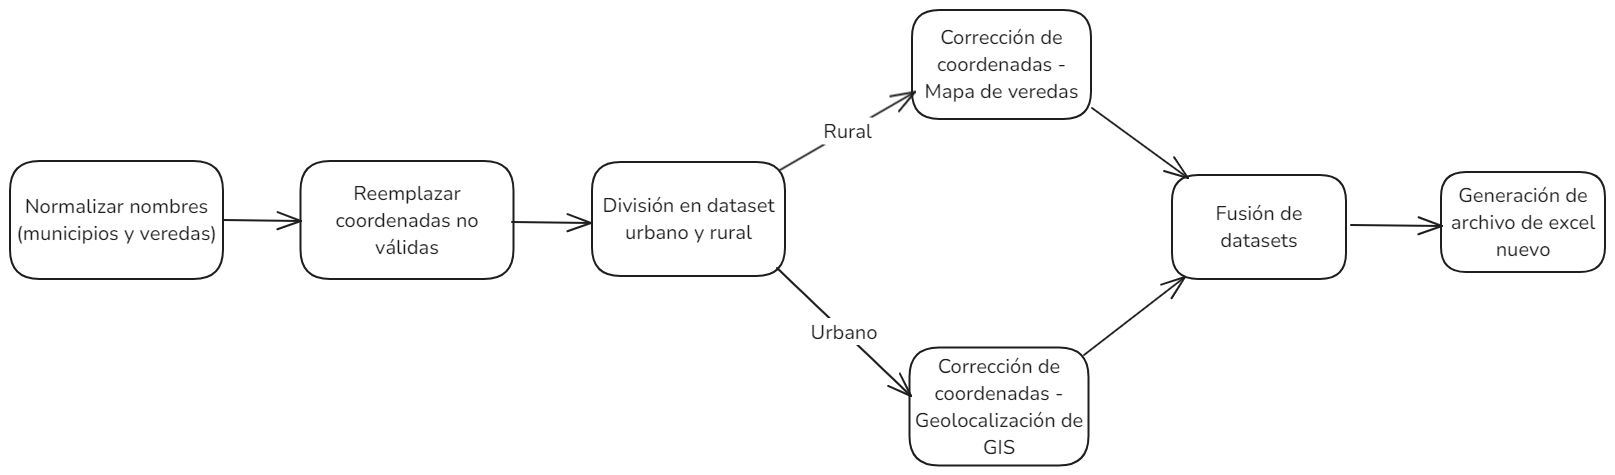

## Detección de coordenadas erróneas

Con el fin de identificar las coordenadas erróneas, es necesario comparar el resultado de la búsqueda con ArcGis con la vereda o el barrio registrado en el dataset.

A través de la API de ArcGis se pueden consultar las veredas con su nombre completo, sin embargo, en el dataset es común encontrarlas con el nombre modificado, incompleto o faltante. Algunos ejemplos que se pueden encontrar en el dataset en la columna "Nombre del Barrio o Vereda (PcD)" son:

- "concepcio" (nombre incompleto)
- "Calle santander 19" (No es el nombre de un barrio o una vereda, es una calle)
- "La pava" (Nombre correcto)

En vista de que debemos comparar y encontrar similitudes entre la vereda o barrio registrado en el dataset y el registrado en ArcGis, es necesario un *Procesamiento de nombres de Barrios y Veredas*, dividido en diferentes fases.



In [1]:
!pip install unidecode
!pip install arcgis
!pip install rapidfuzz
!pip install pandas
!pip install openpyxl

Inicialmente se realiza es proceso de normalización, eliminando las tildes y reescribiendo los nombres en minúsculas, estandarizando así el formato del texto que los métodos van a recibir y haciendo más fácil y precisa la comparación entre dos nombres de localidades.


In [2]:
# Normalización de nombres de municipios, barrios y veredas en la versión limpia del dataset original

from normalizar_texto import agregar_columnas_normalizadas

#file_path = "clean_pcd_data.csv"
file_path = "sampled_file.csv"

# Llamar al método y almacenar el resultado
dataset_actualizado = agregar_columnas_normalizadas(file_path)

# Verificar las nuevas columnas
print(dataset_actualizado[["Municipio_normalizado", "BarrioVereda_normalizado"]].head())


  Municipio_normalizado BarrioVereda_normalizado
0                itagui                 san jose
1              rionegro                   capiro
2                 anori                guacamaya
3              cisneros             calle boyaca
4         san francisco                  inojosa


Adicionalmente, durante la elaboración del presente documento se hizo notable que la presencia de datos "Not a Number" (NaN), especialmente en las columnas sobre las coordenadas (x, y), obstaculizan el procesamiento de los datos. Es por esto que las coordenadas que están vacías o representadas como 0.0 son representadas con las coordenadas del municipio.

In [3]:
import pandas as pd
import verificacion as ver

# Initialize a counter
processed_count = 0

# Wrapper function to track processed rows
def wrapper_with_count(row):
    global processed_count
    # Check if the row meets the invalid state condition before processing
    invalid_states = [None, "", "0.0", "nan"]
    if pd.isna(row["x"]) or pd.isna(row["y"]) or row["x"] in invalid_states or row["y"] in invalid_states:
        processed_count += 1
    return ver.data_verification(row)

# Apply the function using the wrapper
dataset_actualizado = dataset_actualizado.apply(wrapper_with_count, axis=1)

# Display the total number of processed rows
print(f"Total rows processed: {processed_count}")



---------------------------------------------------------------------
Procesando object id 29757
---------------------------------------------------------------------
Procesando object id 36555
Coordenadas encontradas en el dataset original: nan, nan
Geocoding municipio: rionegro
Geocode Results: [{'address': 'Rionegro, Antioquia', 'location': {'x': -75.37413, 'y': 6.15367}, 'score': 100, 'attributes': {'Loc_name': 'World', 'Status': 'T', 'Score': 100, 'Match_addr': 'Rionegro, Antioquia', 'LongLabel': 'Rionegro, Antioquia, COL', 'ShortLabel': 'Rionegro', 'Addr_type': 'Locality', 'Type': 'City', 'PlaceName': 'Rionegro', 'Place_addr': 'Rionegro, Antioquia', 'Phone': '', 'URL': '', 'Rank': 8.5, 'AddBldg': '', 'AddNum': '', 'AddNumFrom': '', 'AddNumTo': '', 'AddRange': '', 'Side': '', 'StPreDir': '', 'StPreType': '', 'StName': '', 'StType': '', 'StDir': '', 'BldgType': '', 'BldgName': '', 'LevelType': '', 'LevelName': '', 'UnitType': '', 'UnitName': '', 'SubAddr': '', 'StAddr': '', 'Block'

Habiendo normalizado los nombres de las veredas y municipios y habiendo rellenado las coordenadas no válidas, el procesamiento de texto se hace mucho más sencillo. A continuación, se evalúan cuáles registros de la columna "Zona de residencia (PcD)" corresponden a la Zona Rural de su municipio y cuáles a la Zona Urbana. Esto porque la Zona Urbana en lugar de estar dividida en veredas, está dividida en barrios, y dichos barrios (así como zonas descritas a partir de nombres de calles o direcciones) no siempre se encuentran disponibles en los mapas de ArcGis para todos los municipios. El procesamiento de direcciones y barrios de las zonas urbanas está destinado para entregas futuras.

In [4]:
import coordenadas_arcgis as ag 

df_urbano, df_rural = ag.dividir_por_zona(dataset_actualizado)

## Procesamiento de coordenadas en la zona rural

### Obtención de coordenadas de las veredas

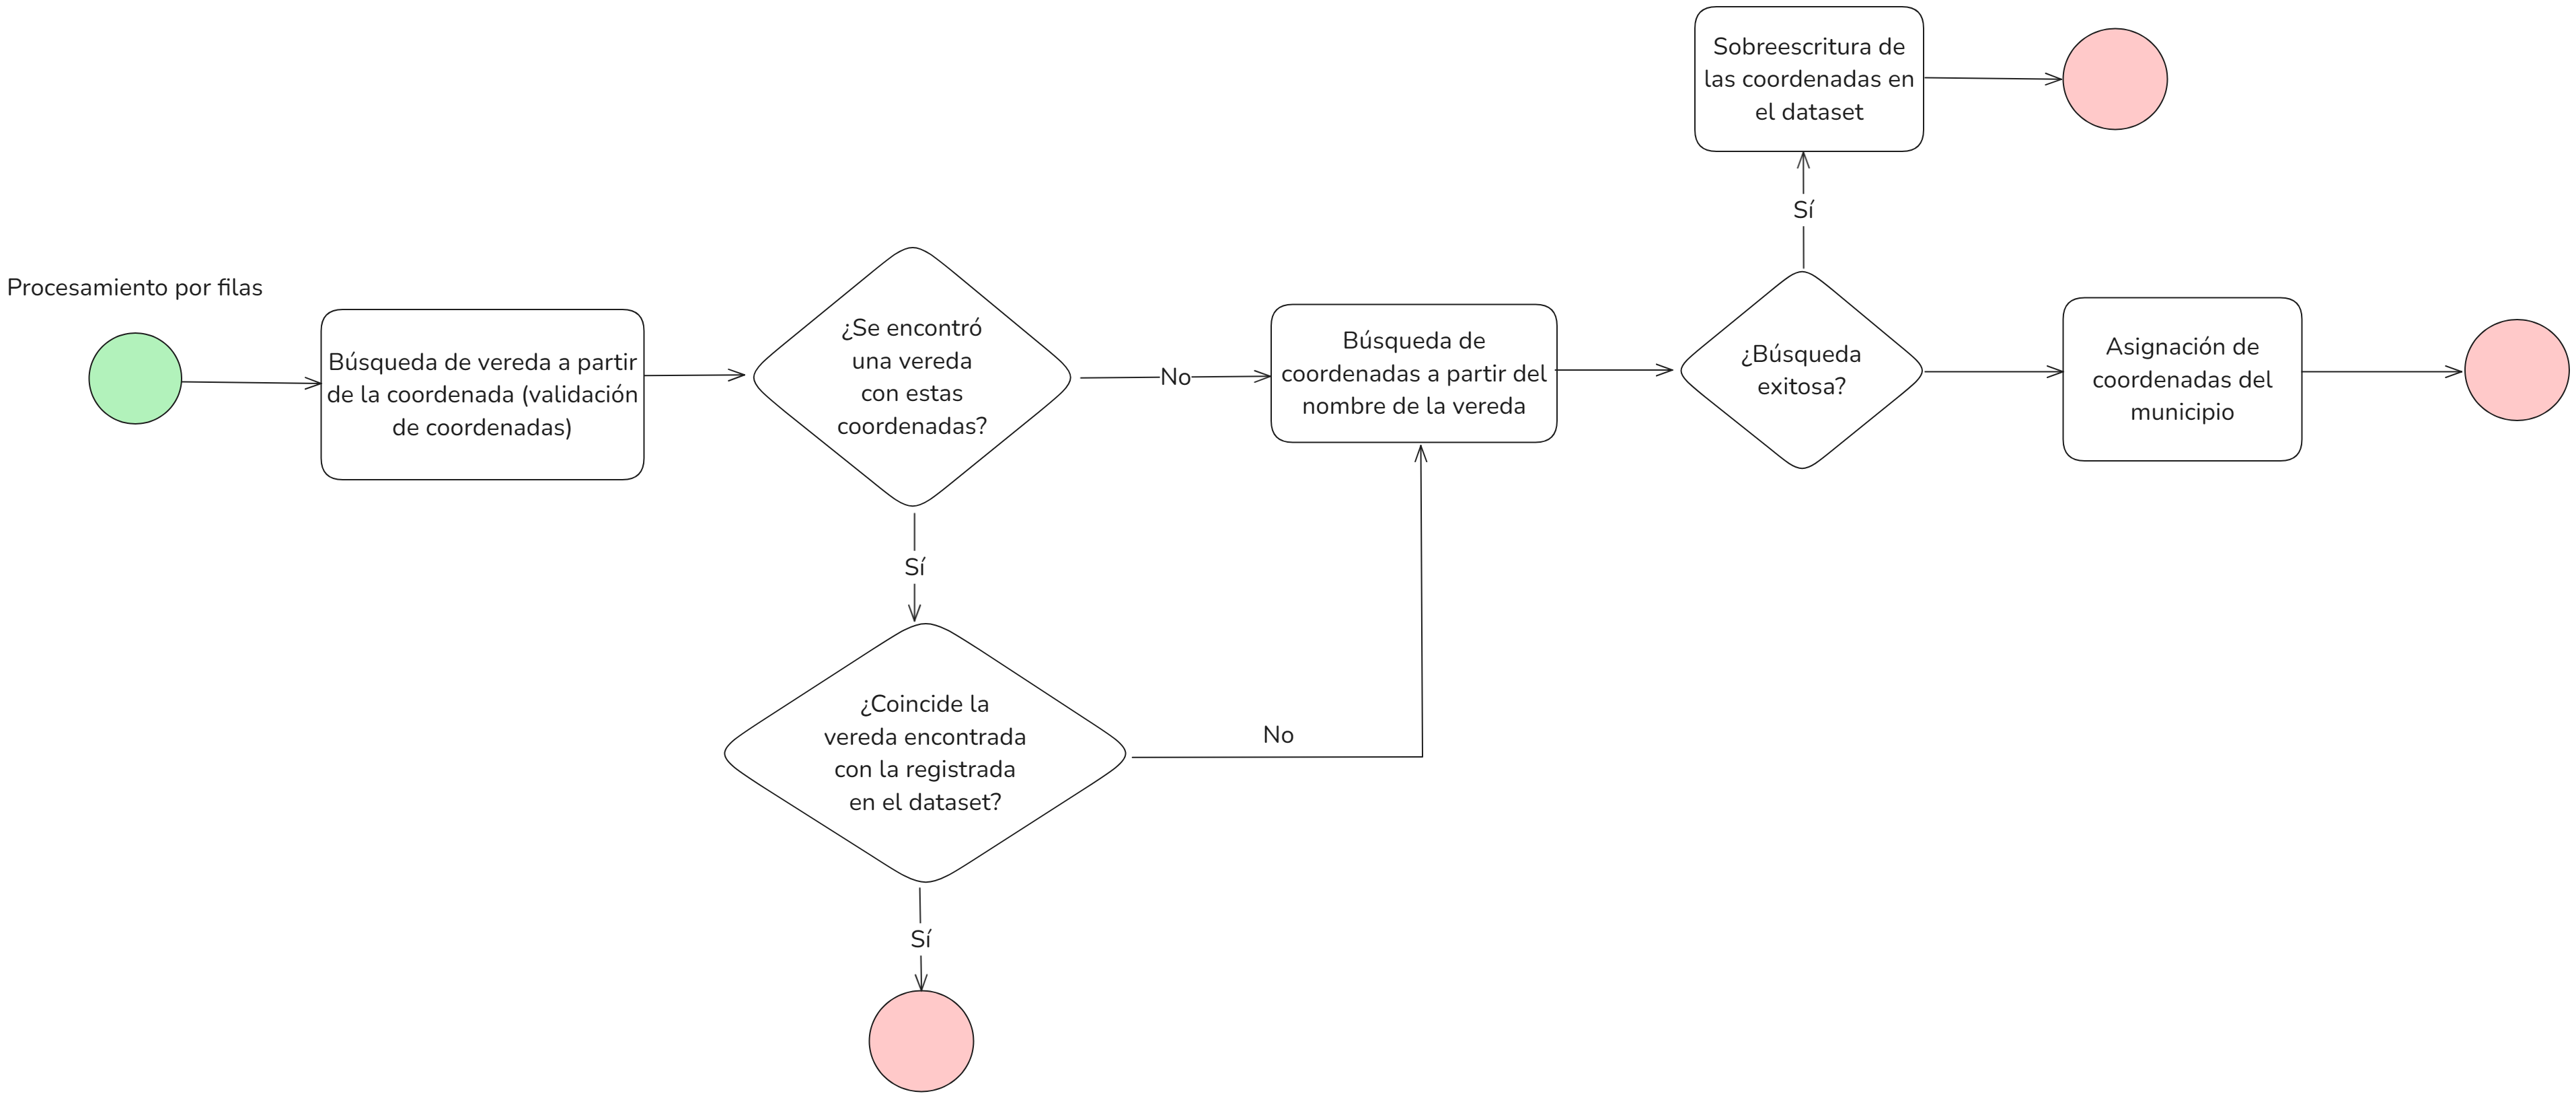

Con el fin de conservar los datos más exactos posibles, se verifica que las coordenadas registradas para cada registro sean las de las veredas especificadas. Si la vereda encontrada con las coordenadas no coincide con la registrada en la encuesta, se intentan registrar las coordenadas de la veredea especificada en la encuesta. Si no se puede encontrar la vereda, se registra el nombre del municipio al que pertenece.

In [5]:
import normalizar_texto as norm
import coincidencia_difusa as cd


def procesar_coordenadas_vereda(row):
    
    vereda_dataset = row["BarrioVereda_normalizado"]
    id = row["ObjectID"]
    print("---------------------------------------------------------------------")
    print(f"Procesando object id {id}. \nVereda normalizada: {vereda_dataset}")

    # Tomar las coordenadas y verificar si están en la vereda
    x = row["x"]
    y = row["y"]
    vereda = ag.query_vereda(x, y)

    # No se encontró una vereda asociada a esas coordenadas
    if vereda == None:
        # Buscar coordenadas de la vereda registrada en el dataset dado el nombre
        print("No se encontró vereda con las coordenadas asignadas. Buscando coordenadas de la vereda registrada...")
        x, y = ag.query_vereda_coordinates(vereda_dataset)

        # Si no se encuentra, se ponen las coordenadas del municipio
        if x is None or y is None:
            # Poner la del municipio***
            id = row["ObjectID"]
            municipio = row["Municipio_normalizado"]
            row["x"], row["y"] = ag.geocode_municipio(municipio)
            print(f"No se pudo encontrar la vereda {vereda_dataset} del registro {id} en el mapa de veredas. \nAsignando coordenadas del municipio {municipio}.")
        
        else:
            print(f"Coordenadas encontradas para {vereda_dataset}: {x}, {y}")
            row["x"] = x
            row["y"] = y
    # Se encontró una vereda asociada a esas coordenadas
    else:
        
        # Normalización de la vereda obtenida desde ArcGis
        vereda_norm = norm.normalizar_texto(vereda)
        print(f"Se encontró una vereda asociada a estas coordenadas: {vereda_norm}. Comparando con la vereda registrada...")

        # Comparar vereda registrada en la encuesta y vereda obtenida en la consulta
        vereda_original = row["BarrioVereda_normalizado"]
        similitud = cd.comparar_frases(vereda_norm, vereda_original, 65)

        print(f"Existe similitud entre {vereda_original} y {vereda_norm}?: {similitud}")

        # Si la similitud es menor al 65% se toma el nombre de la vereda registrada originalmente y se busca en el mapa de veredas
        if not similitud:
            print(f"Similitud entre ambas veredas idemasiado baja o inexistente. Buscando coordenadas de la vereda registrada...")
            x, y = ag.query_vereda_coordinates(vereda_dataset)
            
            # Se intenta encontrar la vereda del dataset en el mapa de veredas
            if x is None or y is None:
                # Poner las coordenadas del municipio
                municipio = row["Municipio_normalizado"]
                row["x"], row["y"] = ag.geocode_municipio(municipio)
                print(f"No se pudo encontrar la vereda {vereda_dataset} en el mapa de veredas. \nAsignando coordenadas del municipio {municipio}.")
            else:
                print(f"Coordenadas encontradas para {vereda_dataset}: {x}, {y}")
                row["x"] = x
                row["y"] = y
            
df_rural.apply(procesar_coordenadas_vereda, axis=1)

---------------------------------------------------------------------
Procesando object id 36555. 
Vereda normalizada: capiro
No se encontró vereda con las coordenadas asignadas. Buscando coordenadas de la vereda registrada...
Coordenadas encontradas para capiro: -75.40202303265198, 6.080454076376787
---------------------------------------------------------------------
Procesando object id 4565. 
Vereda normalizada: inojosa
Se encontró una vereda asociada a estas coordenadas: pocitos. Comparando con la vereda registrada...
Existe similitud entre inojosa y pocitos?: False
Similitud entre ambas veredas idemasiado baja o inexistente. Buscando coordenadas de la vereda registrada...
No se encontraron coincidencias
Geocoding municipio: san francisco
Geocode Results: [{'address': 'San Francisco, Antioquia', 'location': {'x': -74.976944221047, 'y': 5.879794408084}, 'score': 100, 'attributes': {'Loc_name': 'World', 'Status': 'T', 'Score': 100, 'Match_addr': 'San Francisco, Antioquia', 'LongLabe

1      None
4      None
8      None
9      None
13     None
14     None
15     None
16     None
17     None
20     None
29     None
30     None
35     None
37     None
38     None
50     None
52     None
53     None
54     None
56     None
58     None
62     None
63     None
65     None
67     None
72     None
73     None
76     None
78     None
80     None
81     None
82     None
85     None
86     None
89     None
92     None
93     None
94     None
96     None
100    None
104    None
106    None
110    None
111    None
112    None
114    None
117    None
118    None
130    None
133    None
142    None
146    None
149    None
dtype: object

## Procesamiento de coordenadas en la zona urbana

### Verificación de coordenadas

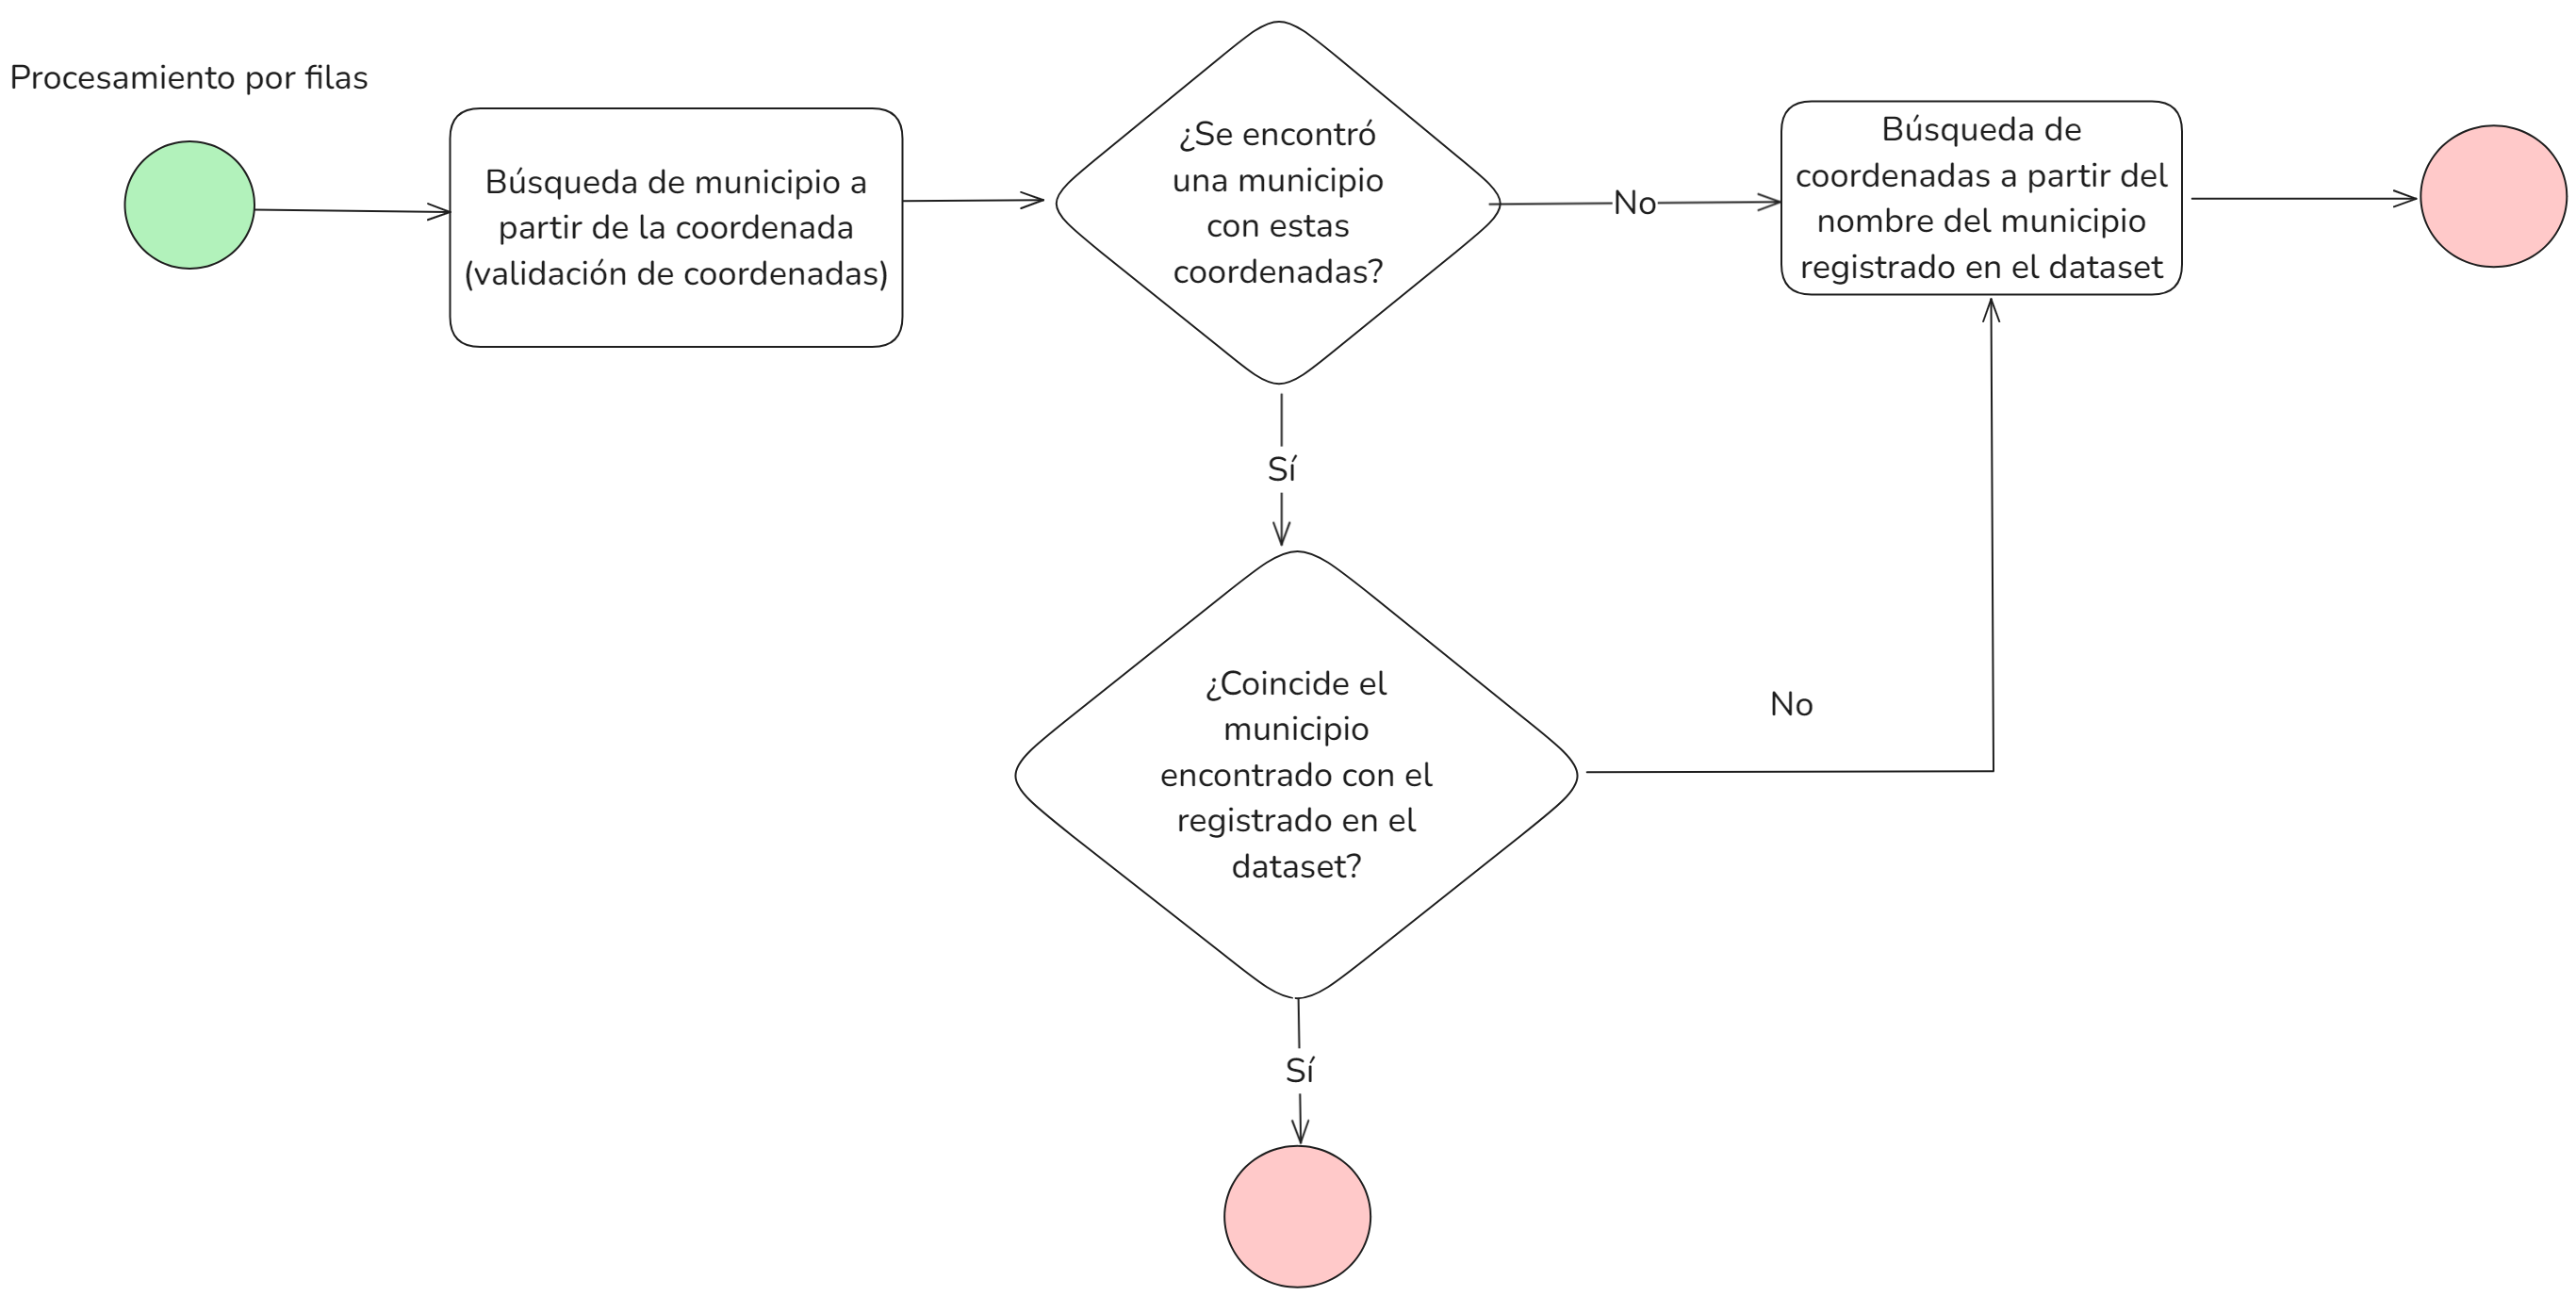

Debido a las limitaciones en el alcance del presente entregable, se tomó la decisión de verificar únicamente, en el caso de las coordenadas pertenecientes a un registro en una Zona Urbana, si las coordenadas presentes registradas estaban dentro del municipio correspondiente. En caso contrario, se le asignan las coordenadas por defecto del municipio.

In [ ]:

def asignar_municipio(municipio):
    print(municipio)
    new_x, new_y = ag.geocode_municipio(municipio)
    print(f"Nuevas coordenadas: {new_x}, {new_y}")
    return new_x, new_y


def procesar_coordenadas_municipio(row):

    municipio_dataset = row["Municipio_normalizado"]
    id = row["ObjectID"]
    print("---------------------------------------------------------------------")
    print(f"Procesando object id {id}. \nMunicipio normalizado: {municipio_dataset}")
    # Saber si las coordenadas registradas hacen parte de algún municipio y cuál
    x = row["x"]
    y = row["y"]
    municipio = ag.reverse_geocode_municipio(x, y)
    if municipio == None:
        print(f"No se encontró el municipio en las coordenadas x, y: {x}, {y}")
        municipio = row["Municipio_normalizado"]
        row["x"], row["y"] = asignar_municipio(municipio)
    else:
        # Normalizar nombre del municipio
        municipio = str(municipio)
        municipio_arcgis = norm.normalizar_texto(municipio)

        # Comparar nombre normalizado del municipio (Se consideran válidas si coinciden al menos en un 70%)
        similitud = cd.comparar_frases(municipio_arcgis, municipio_dataset, 70)
        

        # Si la similitud entre el municipio que marcan las coordenadas y el del dataset es menor al 70%, se ponen las coordenadas del municipio original
        if not similitud:
            print(f"Similitud entre {municipio_dataset} y {municipio_arcgis}: {similitud}")
            municipio = row["Municipio de residencia (PcD)"]
            row["x"], row["y"] = asignar_municipio(municipio)


df_urbano.apply(procesar_coordenadas_municipio, axis=1)

---------------------------------------------------------------------
Procesando object id 29757. 
Municipio normalizado: itagui
Reverse geocoding coordinates: -75.61424, 6.16548
Reverse Geocode Result: {'address': {'Match_addr': 'Distribuidora Accesorios S A S', 'LongLabel': 'Distribuidora Accesorios S A S, Diagonal 38a 34 14, San Jose, Itagüí, Antioquia, COL', 'ShortLabel': 'Distribuidora Accesorios S A S', 'Addr_type': 'POI', 'Type': 'Clothing Store', 'PlaceName': 'Distribuidora Accesorios S A S', 'AddNum': '34 14', 'Address': 'Diagonal 38a 34 14', 'Block': '', 'Sector': '', 'Neighborhood': 'San Jose', 'District': 'Itagüí', 'City': 'Itagüí', 'MetroArea': '', 'Subregion': 'Itagüí', 'Region': 'Antioquia', 'RegionAbbr': 'ANT', 'Territory': '', 'Postal': '055412', 'PostalExt': '', 'CntryName': 'Colombia', 'CountryCode': 'COL', 'X': -75.614186490132, 'Y': 6.163959344018, 'InputX': -75.61424, 'InputY': 6.16548}, 'location': {'x': -75.614186490132, 'y': 6.163959344018, 'spatialReference': 

## Unificación de datasets

En pasos anteriores se dividió el dataset en dos, uno para zona rural y otro para la zona urbana. A continuación se unificarán para la posterior generación del dataset limpio.

In [ ]:
import pandas as pd

df_combined = pd.concat([df_rural, df_urbano], ignore_index=True)
print(df_combined.head())

  ObjectID Fecha de la encuesta Nombres y apellidos del encuestador  \
0    36555           24/07/2023                      Leandro Garcia   
1     4565      6/07/2024 17:00                         Erica henao   
2    31956     19/01/2022 17:00      Maria Yuliana Presiga Cardona    
3    43501  2024-08-12 18:00:00           Anthony Alzate sepulveda    
4    30359     16/11/2022 17:00      Maria Del Carmen Baldrich Mena   

  Tipo de documento del encuestador Numero de documento del encuestador  \
0              Cedula de ciudadania                          15445072.0   
1              Cedula de ciudadania                        1040261406.0   
2              Cedula de ciudadania                        1028121041.0   
3              Cedula de ciudadania                        1033176597.0   
4              Cedula de ciudadania                        1016016541.0   

   Subregion (PcD) Municipio de residencia (PcD) Zona de residencia (PcD)  \
0          Oriente                      Rione

## Generación del nuevo dataset

In [ ]:
# Save to a CSV file
output_file = 'combined_data.xlsx'
df_combined.to_excel(output_file, index=False)

print(f"Data combined and saved to {output_file}")

Data combined and saved to combined_data.xlsx
